<a href="https://www.kaggle.com/code/br0grammer/llm-text-classifier-pytorch-mlp?scriptVersionId=155035905" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-external-train-dataset/train_external_drcat_02.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv


In [2]:
dataset = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [3]:
import matplotlib.pyplot as plt

In [4]:
import random

In [5]:
def clean(text):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
    for char in punc:
        text = text.replace(char, "")
    return text

In [6]:
stoi = {"[PAD]": 0,
       "[UNK]": 1}
itos = {0 : "[PAD]",
       1 : "[UNK]"}
total_text = set()
for index, row in dataset.iterrows():
    if random.randrange(0, 100) >= 99:
        total_text.update(clean(row["text"]).lower().split())
stoi.update({char:i+2 for i, char in enumerate(sorted(total_text))})
itos.update({i+2:char for i, char in enumerate(sorted(total_text))})

In [7]:
itos[stoi['the']]

'the'

In [8]:
vocab_size = len(stoi)
vocab_size

8376

In [9]:
itos[0]

'[PAD]'

In [10]:
class Tokenizer:
    def __init__(self, stoi, itos, max_len=100):
        self.stoi = stoi
        self.itos = itos
        self.vocab_size = len(itos)
        self.max_len = max_len
    def encode(self, text, truncate=True):
        out = []
        if truncate:
            text = text.lower().split()[:self.max_len]
            for word in text:
                if word in stoi:
                    out.append(stoi[word])
                else:
                    out.append(1)
            out = [0] * max(0, abs(len(out) - self.max_len)) + out
        else:
            text = text.lower().split()
            for word in text:
                if word in stoi:
                    out.append(stoi[word])
                else:
                    out.append(1)
        return out
    def decode(self, ids):
        out = ""
        for token in ids:
            if token in itos:
                out += itos[token] + " "
        return out

In [11]:
context_len = 30

In [12]:
tokenizer = Tokenizer(stoi, itos, max_len=context_len)

In [13]:
for i, example in dataset.iterrows():
    print(example)
    break

text             Phones\n\nModern humans today are always on th...
label                                                            0
prompt_name                                     Phones and driving
source                                             persuade_corpus
RDizzl3_seven                                                False
Name: 0, dtype: object


(array([1.5710e+03, 1.8492e+04, 1.6514e+04, 5.2280e+03, 2.0070e+03,
        7.6000e+02, 2.5900e+02, 2.9000e+01, 6.0000e+00, 2.0000e+00]),
 array([   4. ,  169.2,  334.4,  499.6,  664.8,  830. ,  995.2, 1160.4,
        1325.6, 1490.8, 1656. ]),
 <BarContainer object of 10 artists>)

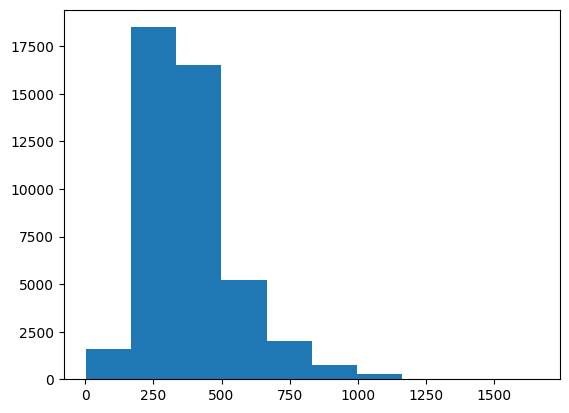

In [14]:
plt.hist([len(tokenizer.encode(example.text, truncate=False)) for i, example in dataset.iterrows()])

In [15]:
tokenizer.encode("Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built")[context_len-20:]

[0,
 0,
 1,
 1118,
 3464,
 712,
 459,
 6725,
 7450,
 698,
 2858,
 3784,
 7416,
 1,
 8120,
 1,
 3054,
 1764,
 341,
 967]

In [16]:
context_len = 30

In [17]:
tokenizer = Tokenizer(stoi, itos, max_len=context_len)

In [18]:
tokenizer.decode(tokenizer.encode("Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built"))

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] cars have been around since they became famous in the [UNK] when [UNK] ford created and built '

In [19]:
import torch

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
test_dataset = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")

In [22]:
def build_dataset():
    xs, ys = [], []
    for index, row in dataset.iterrows():
        xs.append(tokenizer.encode(row["text"]))
        ys.append(row["label"])
    for index, row in test_dataset.iterrows():
        xs.append(tokenizer.encode(row["text"]))
        ys.append(row["generated"])
    xs = torch.tensor(xs).to(device)
    ys = torch.tensor(ys).to(device)
    return xs, ys
xs, ys = build_dataset()

In [23]:
tokenizer.decode(xs[0].cpu().numpy())

'phones modern humans today are always on their [UNK] they are always on their phone more than [UNK] hours a day no stop [UNK] they do is text back and '

In [24]:
ys[0]

tensor(0, device='cuda:0')

In [25]:
emb_dim = 20

In [26]:
# initialize parameters
n_hidden = 200
C = torch.randn(vocab_size, emb_dim).to(device)
w1 = torch.randn(context_len * emb_dim, n_hidden).to(device) / (context_len * emb_dim)**0.5
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn(n_hidden, 2).to(device) / (n_hidden**0.5)
b2 = torch.randn(2).to(device) * 0.01

bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)

params = [C, w1, b1, w2, b2, bngain, bnbias]
for p in params:
    p.requires_grad = True

In [27]:
num_examples = len(xs)

In [28]:
# training params
num_epochs = 100000
lr = 1
batch_size = 64

In [29]:
import torch.nn.functional as F

In [30]:
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9)

In [31]:
epochs = []
losses = []

for epoch in range(num_epochs):
    selection = torch.randint(0, num_examples-1, (batch_size, ))
    ins = xs[selection]
    outs = ys[selection]
    emb = C[ins].view(-1, emb_dim * context_len)
    l1 = (emb @ w1) + b1
    l1 = bngain * ((l1 - l1.mean(0, keepdim=True)) / (l1.std(0, keepdim=True))) + bnbias
    l1 = l1.tanh()
    logits = ((l1 @ w2) + b2).sigmoid()
#     for p in params:
#         p.grad = None
    optimizer.zero_grad()
    
    loss = F.cross_entropy(logits, outs)
    if epoch % 10000 == 0:
        print("Epoch:", epoch, ", loss:", loss.item())
    loss.backward()
    if epoch % 100 == 0:
        epochs.append(epoch)
        losses.append(loss.item())
    
#     for p in params:
#             p.data -= p.grad * (lr / (((epoch+1)/100)**0.5))
    optimizer.step()

Epoch: 0 , loss: 0.7088131904602051
Epoch: 10000 , loss: 0.36619439721107483
Epoch: 20000 , loss: 0.3723144233226776
Epoch: 30000 , loss: 0.34452036023139954
Epoch: 40000 , loss: 0.3401467204093933
Epoch: 50000 , loss: 0.3132981061935425
Epoch: 60000 , loss: 0.32514292001724243
Epoch: 70000 , loss: 0.32888731360435486
Epoch: 80000 , loss: 0.3132619261741638
Epoch: 90000 , loss: 0.3132619261741638


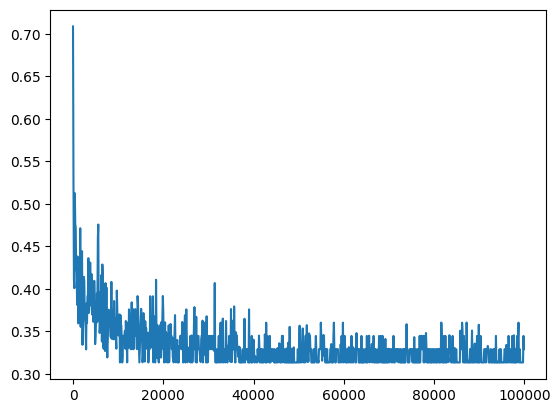

In [32]:
plt.plot(epochs, losses)

In [33]:
with torch.no_grad():
    selection = torch.randint(0, num_examples-1, (1,))
    ins = xs[selection]
    outs = ys[selection]
    emb = C[ins].view(-1, emb_dim * context_len)
    l1 = ((emb @ w1) + b1).tanh()
    logits = ((l1 @ w2) + b2).sigmoid()
    print(tokenizer.decode(ins[0].cpu().numpy()))
    print("prediction:", torch.argmax(logits).item())
    print("truth:", outs[0].item())

dear [UNK] i believe that allowing student to bring phones to school and using them during lunch period and free time but as long as the phones are off during 
prediction: 0
truth: 0


In [34]:
with torch.no_grad():
    while True:
        selection = torch.randint(0, num_examples-1, (1,))
        ins = xs[selection]
        outs = ys[selection]
        emb = C[ins].view(-1, emb_dim * context_len)
        l1 = ((emb @ w1) + b1).tanh()
        logits = ((l1 @ w2) + b2).sigmoid()
        if outs[0].item() == 0:
            print(tokenizer.decode(ins[0].cpu().numpy()))
            print("prediction:", torch.argmax(logits).item(), "confidence:", (logits[0][torch.argmax(logits).item()]/logits.sum()).item())
            print("truth:", outs[0].item())
            print("selection index:", selection.item())
            break

dear [UNK] in my opinion i think that policy is [UNK] many students have a c average because they have practice and [UNK] have time to [UNK] if you were 
prediction: 0 confidence: 1.0
truth: 0
selection index: 16400


In [35]:
def prompt(essay):
    with torch.no_grad():
        ins = torch.tensor(tokenizer.encode(essay))
        emb = C[ins].view(-1, emb_dim * context_len)
        l1 = ((emb @ w1) + b1).tanh()
        logits = ((l1 @ w2) + b2).sigmoid()
        return round((logits[0][1] / logits[0].sum()).item(), 3)

In [36]:
prompt("furthermore, the introduction of cars into modern society assisted with means of transportation")

1.0

In [37]:
prompt("cars are very good because they get us places and are fun")

0.0

In [38]:
tokenizer.decode(xs[96].cpu().numpy())

'today many people are on their phone [UNK] driving at the same [UNK] cell phone use while driving has led to [UNK] million crashes each [UNK] nearly [UNK] injuries have '

In [39]:
prompt(tokenizer.decode(xs[96].cpu().numpy()))

0.0

In [40]:
ys[96]

tensor(0, device='cuda:0')

In [41]:
test_dataset = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

In [42]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["id", "generated"]
    
    writer.writerow(field)
    for index, row in test_dataset.iterrows():
        writer.writerow([row["id"], prompt(row["text"])])

In [43]:
answers = pd.read_csv("/kaggle/working/submission.csv")

In [44]:
for index, row in answers.iterrows():
    print(row)

id           0000aaaa
generated         1.0
Name: 0, dtype: object
id           1111bbbb
generated         1.0
Name: 1, dtype: object
id           2222cccc
generated         1.0
Name: 2, dtype: object
